In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os


In [2]:
DIRECTORY = r'dataset'
CATEGORIES = ["with_mask", "without_mask"]

In [3]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [4]:
data = []
labels = []

In [5]:
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)
    	data.append(image)
    	labels.append(category)

C:\Users\anive\anaconda3\lib\site-packages\PIL\Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [6]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)

In [7]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [8]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

In [9]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [10]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [11]:
for layer in baseModel.layers:
	layer.trainable = False

In [12]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

C:\Users\anive\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [13]:
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

Epoch 1/20
95/95 [==============================] - 103s 1s/step - loss: 0.4079 - accuracy: 0.8609 - val_loss: 0.1710 - val_accuracy: 0.9831
Epoch 2/20
95/95 [==============================] - 92s 967ms/step - loss: 0.1617 - accuracy: 0.9661 - val_loss: 0.0866 - val_accuracy: 0.9883
Epoch 3/20
95/95 [==============================] - 93s 981ms/step - loss: 0.1108 - accuracy: 0.9726 - val_loss: 0.0647 - val_accuracy: 0.9857
Epoch 4/20
95/95 [==============================] - 95s 996ms/step - loss: 0.0832 - accuracy: 0.9776 - val_loss: 0.0519 - val_accuracy: 0.9883
Epoch 5/20
95/95 [==============================] - 97s 1s/step - loss: 0.0717 - accuracy: 0.9825 - val_loss: 0.0453 - val_accuracy: 0.9896
Epoch 6/20
95/95 [==============================] - 98s 1s/step - loss: 0.0639 - accuracy: 0.9819 - val_loss: 0.0447 - val_accuracy: 0.9883
Epoch 7/20
95/95 [==============================] - 98s 1s/step - loss: 0.0593 - accuracy: 0.9832 - val_loss: 0.0392 - val_accuracy: 0.9909
Epoch 8/20

In [14]:
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)


print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))


print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

24/24 [==============================] - 15s 588ms/step
              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767

[INFO] saving mask detector model...


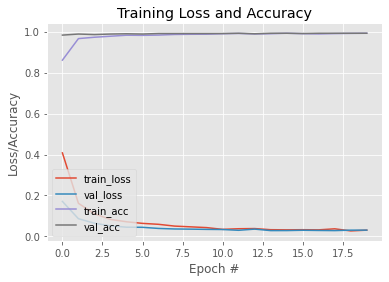

In [15]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [17]:
import pickle

In [18]:
pickle.dump(H,open("model.pkl","wb"))

INFO:tensorflow:Assets written to: ram://8be434d5-ceec-46c8-8476-54d04c9d8e9d/assets


INFO:tensorflow:Assets written to: ram://8be434d5-ceec-46c8-8476-54d04c9d8e9d/assets
